# Warning :
# Do "File -> Save a copy in Drive" before you start modifying the notebook, otherwise your modifications will not be saved.


In [1]:
import argparse
import os
import time

import PIL
from PIL import Image

import numpy as np
import torchvision
import pickle

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.utils.data
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.autograd import Variable

from sklearn.svm import LinearSVC

# Partie 1 : Architecture VGG16

In [2]:
#!wget https://github.com/cdancette/deep-learning-polytech-tp6-7/raw/master/tp8/imagenet_classes.pkl
!wget https://github.com/rdfia/rdfia.github.io/raw/master/data/3-a/imagenet_classes.pkl

# Bonus : Classifiez des exemples avec vgg16 et commentez le résultat dans votre rapport.
!wget --content-disposition https://unsplash.com/photos/gKXKBY-C-Dk/download?force=true -O cat.jpg
!wget --content-disposition https://unsplash.com/photos/qO-PIF84Vxg/download?force=true -O dog.jpg

--2026-01-13 21:07:17--  https://github.com/rdfia/rdfia.github.io/raw/master/data/3-a/imagenet_classes.pkl
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/rdfia/rdfia.github.io/master/data/3-a/imagenet_classes.pkl [following]
--2026-01-13 21:07:17--  https://raw.githubusercontent.com/rdfia/rdfia.github.io/master/data/3-a/imagenet_classes.pkl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35454 (35K) [text/plain]
Saving to: ‘imagenet_classes.pkl’

imagenet_classes.pk 100%[===================>]  34.62K  --.-KB/s    in 0s      

2026-01-13 21:07:17 (202 MB/s) - ‘imagenet_classes.pkl’ saved [35

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:05<00:00, 98.9MB/s]


Predicted class index: 285
Predicted label: Egyptian cat


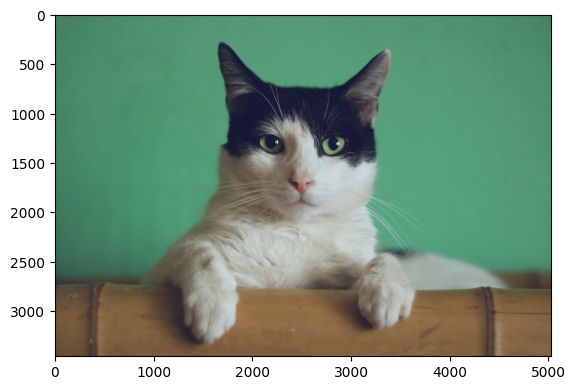

In [3]:
nameim = "cat"+".jpg"
#cat = Image.open('cat.jpg')
img = Image.open(nameim)
plt.imshow(img)

# Loading ImageNet classes
imagenet_classes = pickle.load(open('imagenet_classes.pkl', 'rb'))

# Normalization
img = img.resize((224, 224), Image.BILINEAR)
img = np.array(img, dtype=np.float32) / 255
img = img.transpose((2, 0, 1))
# ImageNet mean/std
mu = torch.Tensor([0.485, 0.456, 0.406])
sigma = torch.Tensor([0.229, 0.224, 0.225])
# Expand mu & sigma to match image size
# YOUR CODE HERE
# compute the normalized image with mean ImageNet image
mu = mu.view(3, 1, 1)
sigma = sigma.view(3, 1, 1)

# img = YOUR CODE HERE
img = (torch.Tensor(img) - mu) / sigma

# Loding pre-trained VGG
vgg16 = torchvision.models.vgg16(pretrained=True)
vgg16.eval() # WHY THAT ?

# Forward pass on VGG
img = np.expand_dims(img, 0)
x = torch.Tensor(img)
y = vgg16(x) # TODO calcul forward
y = y.detach().numpy() # transformation en array numpy

# Get prediction (i.e., ImageNet class label)
# YOUR CODE HERE
class_index = np.argmax(y)
print("Predicted class index:", class_index)
print("Predicted label:", imagenet_classes[class_index])

# Partie 2: Transfer Learning avec VGG16 sur 15 Scene

In [4]:
#!wget https://github.com/cdancette/deep-learning-polytech-tp6-7/raw/master/tp8/15ScenesData.zip
!wget https://github.com/rdfia/rdfia.github.io/raw/master/data/3-a/15ScenesData.zip

!unzip 15ScenesData.zip

--2026-01-13 21:07:29--  https://github.com/rdfia/rdfia.github.io/raw/master/data/3-a/15ScenesData.zip
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/rdfia/rdfia.github.io/master/data/3-a/15ScenesData.zip [following]
--2026-01-13 21:07:29--  https://raw.githubusercontent.com/rdfia/rdfia.github.io/master/data/3-a/15ScenesData.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 86520868 (83M) [application/zip]
Saving to: ‘15ScenesData.zip’

15ScenesData.zip    100%[===================>]  82.51M   497MB/s    in 0.2s    

2026-01-13 21:07:32 (497 MB/s) - ‘15ScenesData.zip’ saved [86520868/86520

In [5]:
ls 15SceneData/test/bedroom/

image_0003.jpg  image_0042.jpg  image_0082.jpg  image_0124.jpg  image_0170.jpg
image_0004.jpg  image_0043.jpg  image_0084.jpg  image_0128.jpg  image_0175.jpg
image_0006.jpg  image_0047.jpg  image_0086.jpg  image_0130.jpg  image_0176.jpg
image_0007.jpg  image_0049.jpg  image_0087.jpg  image_0131.jpg  image_0180.jpg
image_0008.jpg  image_0050.jpg  image_0088.jpg  image_0134.jpg  image_0182.jpg
image_0011.jpg  image_0052.jpg  image_0090.jpg  image_0135.jpg  image_0189.jpg
image_0013.jpg  image_0053.jpg  image_0092.jpg  image_0138.jpg  image_0190.jpg
image_0014.jpg  image_0054.jpg  image_0093.jpg  image_0140.jpg  image_0191.jpg
image_0016.jpg  image_0056.jpg  image_0095.jpg  image_0141.jpg  image_0192.jpg
image_0017.jpg  image_0059.jpg  image_0096.jpg  image_0142.jpg  image_0195.jpg
image_0018.jpg  image_0060.jpg  image_0097.jpg  image_0144.jpg  image_0196.jpg
image_0019.jpg  image_0062.jpg  image_0098.jpg  image_0148.jpg  image_0200.jpg
image_0020.jpg  image_0063.jpg  image_0103.jpg  imag

In [6]:
class VGG16relu7(nn.Module):
  def __init__(self):
    super(VGG16relu7, self).__init__()
    # Use VGG16 pretrained
    vgg16 = models.vgg16(pretrained=True)
    # Copy the entire feature extractor
    self.features = nn.Sequential(*list(vgg16.features.children()))
    # Copy the classifier part up to relu7 (-2 excludes the last Linear and Dropout)
    self.classifier = nn.Sequential(*list(vgg16.classifier.children())[:-2])

  def forward(self, x):
    x = self.features(x)
    x = x.view(x.size(0), -1)
    x = self.classifier(x)
    return x

In [7]:

PRINT_INTERVAL = 50
CUDA = True

def get_dataset(batch_size, path):

    # This function expands 3 times a gray level image
    # to transform it into an image RGB. Use it with transform.Lambda
    def duplicateChannel(img):
        img = img.convert('L')
        np_img = np.array(img, dtype=np.uint8)
        np_img = np.dstack([np_img, np_img, np_img])
        img = Image.fromarray(np_img, 'RGB')
        return img
    def resizeImage(img):
      return img.resize((224,224), Image.BILINEAR)

    #####################
    ## YOUR CODE HERE  ##
    #####################
    # Add pre-processing
    train_dataset = datasets.ImageFolder(path+'/train',
        transform=transforms.Compose([
            transforms.Lambda(duplicateChannel),
            transforms.Lambda(resizeImage),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ]))
    val_dataset = datasets.ImageFolder(path+'/test',
        transform=transforms.Compose([
            transforms.Lambda(duplicateChannel),
            transforms.Lambda(resizeImage),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ]))
    ####################
    ##      END        #
    ####################

    train_loader = torch.utils.data.DataLoader(train_dataset,
                        batch_size=batch_size, shuffle=False, pin_memory=CUDA, num_workers=2)
    val_loader = torch.utils.data.DataLoader(val_dataset,
                        batch_size=batch_size, shuffle=False, pin_memory=CUDA, num_workers=2)

    return train_loader, val_loader

In [11]:
def extract_features(data, model):
    #####################
    ## YOUR CODE HERE  ##
    #####################
    # init features matrices
    X = []
    y = []
    ####################
    ##      END        #
    ####################

    for i, (input, target) in enumerate(data):
        if i % PRINT_INTERVAL == 0:
            print('Batch {0:03d}/{1:03d}'.format(i, len(data)))
        if CUDA:
            input = input.cuda()
        #####################
        ## YOUR CODE HERE  ##
        #####################
        # Forward pass
        with torch.no_grad():
            features = model(input)

        # Move to CPU and convert
        features = features.cpu().numpy()
        target = target.numpy()

        X.append(features)
        y.append(target)
    #   Concatenate all batches
    X = np.concatenate(X, axis=0)
    y = np.concatenate(y, axis=0)
        ####################
        ##      END        #
        ####################

    return X, y


def main(path="15SceneData", batch_size=8):
    print('Instanciation de VGG16')
    vgg16 = models.vgg16(pretrained=True)

    print('Instanciation de VGG16relu7')
    #####################
    ## YOUR CODE HERE  ##
    #####################
    # Remplacer par le modèle par un réseau tronqué pour faire de la feature extraction
    # On créera une nouvelle classe VGG16relu7 ici
    model = vgg16
    model = VGG16relu7()
    ####################
    ##      END        #
    ####################

    model.eval()
    if CUDA: # si on fait du GPU, passage en CUDA
        cudnn.benchmark = True
        model = model.cuda()

    # On récupère les données
    print('Récupération des données')
    train, test = get_dataset(batch_size, path)

    # Extraction des features
    print('Feature extraction')
    X_train, y_train = extract_features(train, model)
    X_test, y_test = extract_features(test, model)

    #####################
    ## Votre code ici  ##
    #####################
    # Apprentissage et évaluation des SVM à faire
    # L2 NORMALIZATION (Required by PDF)
    # X_train = X_train / np.linalg.norm(X_train, axis=1, keepdims=True)
    # X_test = X_test / np.linalg.norm(X_test, axis=1, keepdims=True)
    print('Apprentissage des SVM')
    clf = LinearSVC(C=1.0)
    clf.fit(X_train, y_train)
    accuracy = clf.score(X_test, y_test)
    print('Accuracy = %f' % accuracy)
    ####################
    ##      FIN        #
    ####################

In [12]:
main("15SceneData", 8)

Instanciation de VGG16


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Instanciation de VGG16relu7
Récupération des données
Feature extraction


/tmp/ipython-input-1268006832.py:12: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  img = Image.fromarray(np_img, 'RGB')
/tmp/ipython-input-1268006832.py:12: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  img = Image.fromarray(np_img, 'RGB')


Batch 000/188
Batch 050/188
Batch 100/188
Batch 150/188


/tmp/ipython-input-1268006832.py:12: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  img = Image.fromarray(np_img, 'RGB')
/tmp/ipython-input-1268006832.py:12: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  img = Image.fromarray(np_img, 'RGB')


Batch 000/374
Batch 050/374
Batch 100/374
Batch 150/374
Batch 200/374
Batch 250/374
Batch 300/374
Batch 350/374
Apprentissage des SVM
Accuracy = 0.885762


/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


# **Question 11** Testing on diffrent C, PCA, And Changing Extraction Layer

In [13]:
import torch
import torch.nn as nn
import torchvision.models as models
import numpy as np
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score

# Configuration
CUDA = torch.cuda.is_available()
PRINT_INTERVAL = 50

# 1️⃣ Définition de la classe VGG16relu7 (Feature Extractor)
class VGG16relu7(nn.Module):
    def __init__(self):
        super(VGG16relu7, self).__init__()
        # Charger VGG16 pré-entraîné
        vgg16 = models.vgg16(pretrained=True)

        # Copier la partie Convolutionnelle (Features)
        self.features = nn.Sequential(*list(vgg16.features.children()))

        # Copier la partie Classifier mais s'arrêter à relu7 [cite: 82, 90]
        # On enlève les 2 dernières couches (Dropout + FC finale 1000 classes)
        self.classifier = nn.Sequential(*list(vgg16.classifier.children())[:-2])

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1) # Flatten (Aplatir) [cite: 111]
        x = self.classifier(x)
        return x

# 2️⃣ Fonction d'extraction des features
def extract_features(data, model):
    # Init arrays
    X = []
    y = []

    model.eval() # Toujours en mode eval ! [cite: 58, 72]

    for i, (input, target) in enumerate(data):
        if i % PRINT_INTERVAL == 0:
            print('Batch {0:03d}/{1:03d}'.format(i, len(data)))

        if CUDA:
            input = input.cuda()

        # Forward pass
        with torch.no_grad():
            features = model(input)

        # Move to CPU and convert to numpy
        features = features.cpu().numpy()
        target = target.numpy()

        X.append(features)
        y.append(target)

    # Concatenate all batches into big arrays
    X = np.concatenate(X, axis=0)
    y = np.concatenate(y, axis=0)

    return X, y

# 3️⃣ Fonction Main avec Comparaison Sans PCA vs Avec PCA
def main(path="15SceneData", batch_size=8):
    print('🏗️ Instanciation de VGG16relu7...')
    model = VGG16relu7()

    if CUDA:
        print("🚀 Utilisation du GPU (CUDA)")
        model = model.cuda()
    else:
        print("🐢 Utilisation du CPU")

    # Récupération des données
    print('📂 Récupération des données...')
    try:
        # Placeholder pour la fonction get_dataset de votre TP
        train, test = get_dataset(batch_size, path)
    except NameError:
        print("⚠️ Erreur: La fonction 'get_dataset' n'est pas définie ici (assurez-vous de l'avoir exécutée).")
        return

    # Extraction des features
    print('🔍 Feature extraction (Train)...')
    X_train, y_train = extract_features(train, model)
    print('🔍 Feature extraction (Test)...')
    X_test, y_test = extract_features(test, model)

    print(f"Dimensions Features Brutes: {X_train.shape}")

    # --- NORMALISATION L2 (Très important pour SVM) --- [cite: 95]
    print('⚖️ Normalisation L2...')
    X_train = X_train / np.linalg.norm(X_train, axis=1, keepdims=True)
    X_test = X_test / np.linalg.norm(X_test, axis=1, keepdims=True)

    # ==========================================
    # PARTIE A : SVM SANS PCA (Full Features)
    # ==========================================
    print('\n🤖 [PARTIE A] Apprentissage SVM SANS PCA (4096 dimensions)...')
    C_values = [0.001, 0.01, 0.1, 1.0, 10.0]

    print(f"{'C Value':<10} | {'Accuracy (No PCA)':<20}")
    print("-" * 35)

    for c_val in C_values:
        clf = LinearSVC(C=c_val, max_iter=10000) # [cite: 118]
        clf.fit(X_train, y_train)
        pred = clf.predict(X_test)
        acc = accuracy_score(y_test, pred) # [cite: 119]
        print(f"{c_val:<10} | {acc:.4f}")

    # ==========================================
    # PARTIE B : SVM AVEC PCA (Reduced Features)
    # ==========================================
    print('\n📉 [PARTIE B] Application de la PCA (Réduction vers 128 dims)...') #
    pca = PCA(n_components=128)
    pca.fit(X_train) # Fit uniquement sur le Train !
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)
    print(f"Dimensions après PCA: {X_train_pca.shape}")

    print('\n🤖 Apprentissage SVM AVEC PCA (128 dimensions)...')
    print(f"{'C Value':<10} | {'Accuracy (PCA)':<20}")
    print("-" * 35)

    results_pca = []
    for c_val in C_values:
        clf = LinearSVC(C=c_val, max_iter=10000)
        clf.fit(X_train_pca, y_train)
        pred = clf.predict(X_test_pca)
        acc = accuracy_score(y_test, pred)
        results_pca.append((c_val, acc))
        print(f"{c_val:<10} | {acc:.4f}")

    best_c, best_acc = max(results_pca, key=lambda x: x[1])
    print("\n🏆 Meilleur résultat (PCA) : C={} avec Accuracy={:.4f}".format(best_c, best_acc))

# Pour lancer le main
if __name__ == '__main__':
    main()

🏗️ Instanciation de VGG16relu7...


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


🚀 Utilisation du GPU (CUDA)
📂 Récupération des données...
🔍 Feature extraction (Train)...


/tmp/ipython-input-1268006832.py:12: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  img = Image.fromarray(np_img, 'RGB')
/tmp/ipython-input-1268006832.py:12: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  img = Image.fromarray(np_img, 'RGB')


Batch 000/188
Batch 050/188
Batch 100/188
Batch 150/188
🔍 Feature extraction (Test)...


/tmp/ipython-input-1268006832.py:12: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  img = Image.fromarray(np_img, 'RGB')
/tmp/ipython-input-1268006832.py:12: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  img = Image.fromarray(np_img, 'RGB')


Batch 000/374
Batch 050/374
Batch 100/374
Batch 150/374
Batch 200/374
Batch 250/374
Batch 300/374
Batch 350/374
Dimensions Features Brutes: (1500, 4096)
⚖️ Normalisation L2...

🤖 [PARTIE A] Apprentissage SVM SANS PCA (4096 dimensions)...
C Value    | Accuracy (No PCA)   
-----------------------------------
0.001      | 0.8238
0.01       | 0.8412
0.1        | 0.8734
1.0        | 0.8881
10.0       | 0.8861

📉 [PARTIE B] Application de la PCA (Réduction vers 128 dims)...
Dimensions après PCA: (1500, 128)

🤖 Apprentissage SVM AVEC PCA (128 dimensions)...
C Value    | Accuracy (PCA)      
-----------------------------------
0.001      | 0.8224
0.01       | 0.8385
0.1        | 0.8690
1.0        | 0.8814
10.0       | 0.8737

🏆 Meilleur résultat (PCA) : C=1.0 avec Accuracy=0.8814


In [14]:
import torch
import torch.nn as nn
import torchvision.models as models
import numpy as np
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score

# Configuration
CUDA = torch.cuda.is_available()
PRINT_INTERVAL = 50

# 1️⃣ Class VGG16relu7 (Standard approach - FC Layer)
class VGG16relu7(nn.Module):
    def __init__(self):
        super(VGG16relu7, self).__init__()
        vgg16 = models.vgg16(pretrained=True)
        # Features + Flatten + Classifier up to ReLU7
        self.features = nn.Sequential(*list(vgg16.features.children()))
        self.classifier = nn.Sequential(*list(vgg16.classifier.children())[:-2])

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# 2️⃣ NEW Class VGG16Conv5 (Early Extraction - Spatial Layer)
class VGG16Conv5(nn.Module):
    def __init__(self):
        super(VGG16Conv5, self).__init__()
        vgg16 = models.vgg16(pretrained=True)
        # Only keep the convolutional part (features)
        # Output is 512 x 7 x 7
        self.features = nn.Sequential(*list(vgg16.features.children()))
        # No classifier part

    def forward(self, x):
        x = self.features(x)
        # Flatten the spatial dimensions (512*7*7 = 25088)
        x = x.view(x.size(0), -1)
        return x

# 3️⃣ Extraction Function
def extract_features(data, model):
    X = []
    y = []
    model.eval()

    for i, (input, target) in enumerate(data):
        if i % PRINT_INTERVAL == 0:
            print(f'Batch {i:03d}/{len(data):03d}')
        if CUDA:
            input = input.cuda()

        with torch.no_grad():
            features = model(input)

        features = features.cpu().numpy()
        target = target.numpy()
        X.append(features)
        y.append(target)

    X = np.concatenate(X, axis=0)
    y = np.concatenate(y, axis=0)
    return X, y

# 4️⃣ Helper to Train/Evaluate SVM
def evaluate_svm(X_train, y_train, X_test, y_test, label="Model"):
    print(f'\n🤖 Training SVM for {label} (Dim: {X_train.shape[1]})...')

    # L2 Normalization
    X_train = X_train / np.linalg.norm(X_train, axis=1, keepdims=True)
    X_test = X_test / np.linalg.norm(X_test, axis=1, keepdims=True)

    # Use PCA if dimensions are too huge (e.g., > 10k) to speed up
    if X_train.shape[1] > 10000:
        print(f"   ⚠️ High dim ({X_train.shape[1]}), applying PCA -> 512 for speed...")
        pca = PCA(n_components=512)
        pca.fit(X_train)
        X_train = pca.transform(X_train)
        X_test = pca.transform(X_test)
        print(f"   📉 New Dim: {X_train.shape[1]}")

    clf = LinearSVC(C=1.0, max_iter=5000)
    clf.fit(X_train, y_train)
    acc = clf.score(X_test, y_test)
    print(f"   🏆 Accuracy ({label}): {acc:.4f}")
    return acc

# 5️⃣ Main Comparison
def main(path="15SceneData", batch_size=8):

    # Get Data
    try:
        train, test = get_dataset(batch_size, path)
    except NameError:
        print("⚠️ Error: 'get_dataset' function missing.")
        return

    # --- MODEL 1: ReLU7 (Late Fusion) ---
    print('\n🔹 [TEST 1] Extracting from ReLU7 (FC Layer)...')
    model_fc = VGG16relu7()
    if CUDA: model_fc = model_fc.cuda()

    X_train_fc, y_train = extract_features(train, model_fc)
    X_test_fc, y_test = extract_features(test, model_fc)

    evaluate_svm(X_train_fc, y_train, X_test_fc, y_test, label="ReLU7 (FC)")

    # --- MODEL 2: Conv5 (Early Fusion) ---
    print('\n🔹 [TEST 2] Extracting from Conv5 (Spatial Layer)...')
    model_conv = VGG16Conv5()
    if CUDA: model_conv = model_conv.cuda()

    X_train_conv, y_train = extract_features(train, model_conv)
    X_test_conv, y_test = extract_features(test, model_conv)

    evaluate_svm(X_train_conv, y_train, X_test_conv, y_test, label="Conv5 (Spatial)")

if __name__ == '__main__':
    main()


🔹 [TEST 1] Extracting from ReLU7 (FC Layer)...


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipython-input-1268006832.py:12: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  img = Image.fromarray(np_img, 'RGB')
/tmp/ipython-input-1268006832.py:12: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  img = Image.fromarray(np_img, 'RGB')


Batch 000/188
Batch 050/188
Batch 100/188
Batch 150/188


/tmp/ipython-input-1268006832.py:12: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  img = Image.fromarray(np_img, 'RGB')
/tmp/ipython-input-1268006832.py:12: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  img = Image.fromarray(np_img, 'RGB')


Batch 000/374
Batch 050/374
Batch 100/374
Batch 150/374
Batch 200/374
Batch 250/374
Batch 300/374
Batch 350/374

🤖 Training SVM for ReLU7 (FC) (Dim: 4096)...
   🏆 Accuracy (ReLU7 (FC)): 0.8881

🔹 [TEST 2] Extracting from Conv5 (Spatial Layer)...


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipython-input-1268006832.py:12: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  img = Image.fromarray(np_img, 'RGB')
/tmp/ipython-input-1268006832.py:12: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  img = Image.fromarray(np_img, 'RGB')


Batch 000/188
Batch 050/188
Batch 100/188
Batch 150/188


/tmp/ipython-input-1268006832.py:12: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  img = Image.fromarray(np_img, 'RGB')
/tmp/ipython-input-1268006832.py:12: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  img = Image.fromarray(np_img, 'RGB')


Batch 000/374
Batch 050/374
Batch 100/374
Batch 150/374
Batch 200/374
Batch 250/374
Batch 300/374
Batch 350/374

🤖 Training SVM for Conv5 (Spatial) (Dim: 25088)...
   ⚠️ High dim (25088), applying PCA -> 512 for speed...
   📉 New Dim: 512
   🏆 Accuracy (Conv5 (Spatial)): 0.8982
